# GUIA 3

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
import random
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.image as mpimg
from scipy.stats import norm
from sklearn.mixture import GaussianMixture
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import FactorAnalysis
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

### Ejercicio 1

![image.png](enunciados/ej1.png)

Partiendo de la densidad conjunta $p_{XY}(x, y)$, podemos intentar factorizarla en dos funciones, de forma de que se cumpla que una de ellas solo dependa de x, y la otra dependa de x e y, tal que 


$p_{XY}(x, y) = p_X(x) \cdot p{Y|X}(y|x)$

$ \frac{ e^{ -( 2x + \frac{ y }{ 4x+2 } ) } }{ 2x+1 } \cdot 1 \{ x > 0, y > 0\} = 2 \cdot e^{-2x} \cdot 1 \{ x>0 \} \cdot \frac{1}{4x+2} e^{- \frac{1}{4x+2}y} \cdot 1 \{ y>0 \}$

Se puede ver que

$X \sim \varepsilon(2) $

Y que

$Y|_{X = x} \sim \varepsilon (\frac{1}{4x+2}) $

Entonces, si $T \sim \varepsilon( \lambda )$ entonces $k \cdot T \sim \varepsilon( \frac {\lambda}{k} )$ se puede decir que

$Y = \varepsilon(1) \cdot (4X+2) $


Habiendolo factorizado de este modo, X corresponde como la causa, e Y es el efecto.

### Ejercicio 2

![image.png](enunciados/ej2.png)

In [3]:
# Cargamos los datos

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


#del x_train, y_train, x_test, y_test


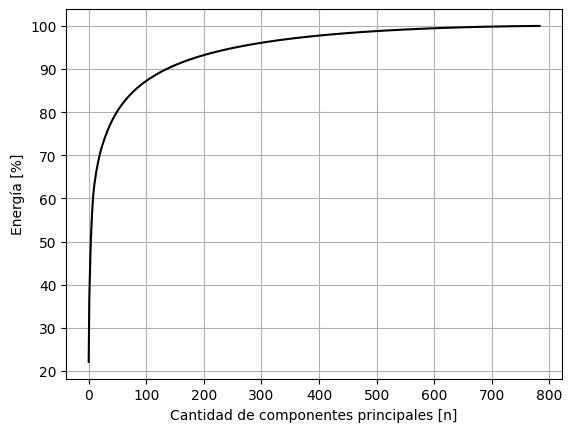

In [33]:
# a)

n_samples_train = x_train.shape[0]
n_samples_test = x_test.shape[0]
X_train = x_train.reshape(n_samples_train, -1)  # Cada imagen es ahora un vector de 784 elementos
X_test = x_test.reshape(n_samples_test, -1)
# Tengo 60000 vectores de 784 elementos (28x28 de c/imagen)

# Calculo la media y la varianza para normalizar
u_train = np.mean(X_train, axis=0)
var_train = np.std(X_train, axis=0)

# Normalizo
X_train_norm = (X_train - u_train)/var_train

# Calculo matriz de covarianza
cov_train = np.cov(X_train_norm.T)

# Calculo AVals, AVecs de la matriz de covarianza
avals, avecs = np.linalg.eig(cov_train)

# Busco los indices que me ordenan los autovalores de mayor a menor
# Igual np.linalg.eig() me parece que los devuelve ordenados de mayor a menor
index_ordenado = np.argsort(avals)[::-1]
avals = avals[index_ordenado]
avecs = avecs[:, index_ordenado]

# Calculo potencias
potencias =  np.cumsum(avals) / np.sum(avals) * 100

# Grafico

plt.figure()
plt.plot(potencias, color = 'k')
plt.xlabel('Cantidad de componentes principales [n]')
plt.ylabel('Energía [%]')
plt.grid(True)
plt.show()


#del n_samples_train, n_samples_test, X_train, X_test, u_train, var_train
#del X_train_norm, cov_train, avals, avecs, index_ordenado, potencias


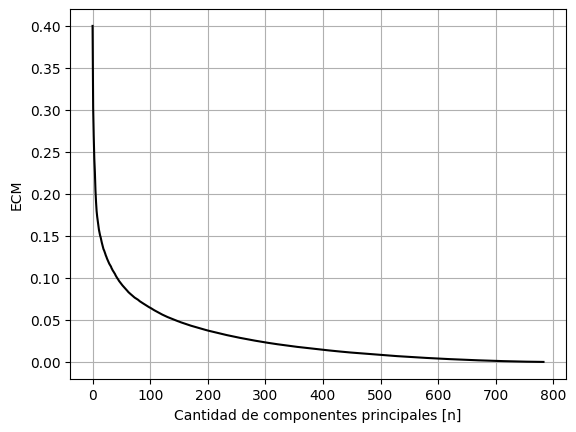

In [34]:
# b) ECM de testeo vs. Cant de componentes principales

def reconstruccion (x_est_ant, avec_n, x):
    return x_est_ant + np.dot(x, avec_n) * avec_n


X_test_norm = (X_test - u_train) / var_train

ECMs = []

for j in range(n_samples_test):
    X_est_ant = np.zeros_like(X_test_norm[j])
    ECM = []
    for i in range(784):
        X_est = reconstruccion(X_est_ant, avecs[:, i], X_test_norm[j])
        reconst = X_est * var_train + u_train
        ECM.append(np.mean((X_test[j] - reconst)**2))
        X_est_ant = X_est
    ECMs.append(ECM)    

ECM_matrix = np.array(ECMs)


ECM = np.mean(ECM_matrix, axis=0)/X_test.shape[0] # axis=0 promedia todas las filas (10000 imágenes)

plt.figure()
plt.plot(ECM, color = 'k')
plt.xlabel('Cantidad de componentes principales [n]')
plt.ylabel('ECM')
plt.grid(True)
plt.show()


#del X_test_norm, ECMs, i, j, X_est_ant, ECM, X_est, reconst, ECM_matrix




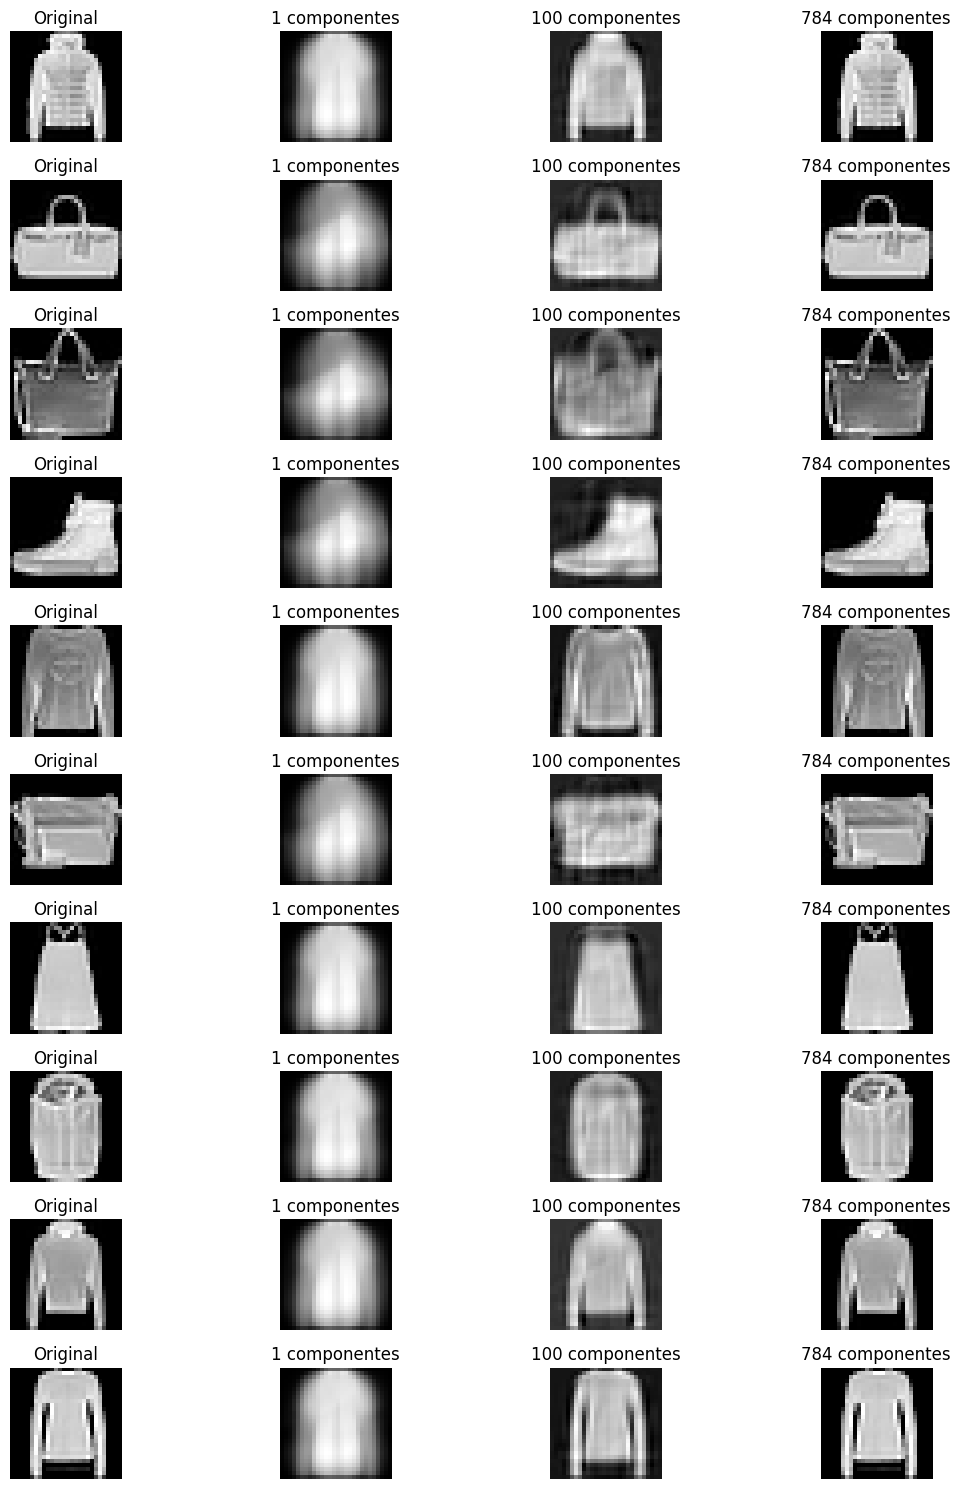

In [ ]:
# c) Elegir 10 img al azar y comparar su reconstr usando 1, 100 y 784 CP


num_images = 10
random_indices = random.sample(range(X_test.shape[0]), num_images)
imagenes_test = X_test[random_indices]
imagenes_test = imagenes_test.reshape(imagenes_test.shape[0], -1)

componentes = [1, 100, 784]

# Configurar la figura para mostrar las imágenes originales y reconstruidas
fig, axes = plt.subplots(num_images, len(componentes) + 1, figsize=(12, 15))


for i, img in enumerate(imagenes_test):
    # Muestro la imagen original
    axes[i, 0].imshow(img.reshape(28, 28), cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    # Centro la imagen
    #img_centered = (img - u_train)
    img_centered = (img - u_train) / var_train
    

    for j, k in enumerate(componentes):
        # Proyecto y reconstruyo con k componentes principales
        transformed_img_k = np.dot(img_centered, avecs[:, :k])
        #reconstructed_img_k = np.dot(transformed_img_k, avecs[:, :k].T) + u_train
        reconstructed_img_k = var_train * np.dot(transformed_img_k, avecs[:, :k].T) + u_train


        # Muestro la imagen reconstruida
        axes[i, j + 1].imshow(reconstructed_img_k.reshape(28, 28), cmap='gray')
        axes[i, j + 1].set_title(f'{k} componentes')
        axes[i, j + 1].axis("off")

plt.tight_layout()
plt.show()


#del num_images, random_indices, imagenes_test, componentes, fig, axes, i, img, img_centered, j, k, transformed_img_k, reconstructed_img_k



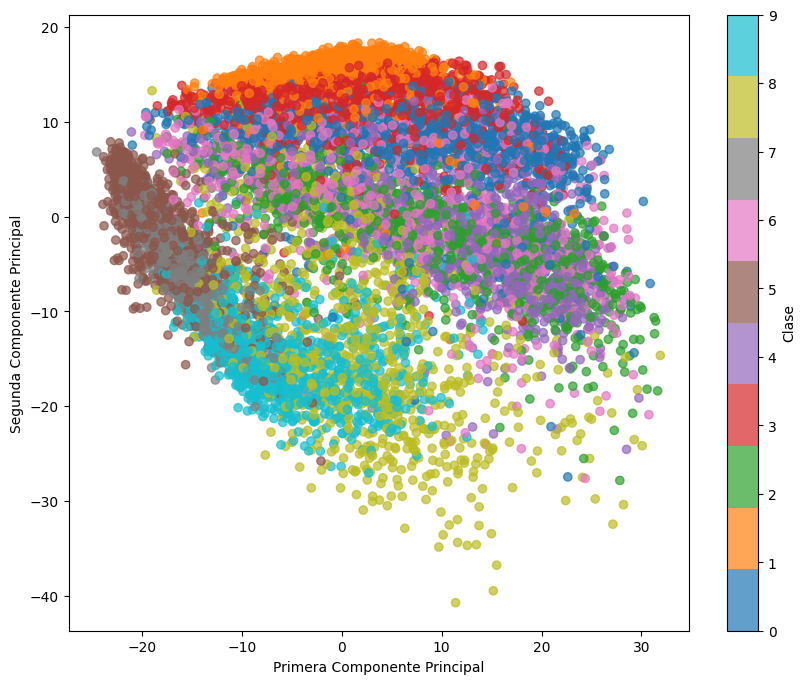

In [ ]:
# d) scatter de las dos primeras CP de las img_test, 1 color p/c/clase

# Vuelvo a traer las imagenes para incluir los labels
(_, _), (test_images, test_labels) = fashion_mnist.load_data()
data_test = test_images.reshape(test_images.shape[0], -1)  # Aplana las imágenes

#Normalizo
data_test_centered = (data_test - u_train) / var_train 

# Proyectar los datos de prueba en las dos primeras componentes principales
# Con avecs[:, :2] uso solo las primeras 2 CP
transformed_data_2d = np.dot(data_test_centered, avecs[:, :2])

# Graficar el scatter plot con colores según la clase
plt.figure(figsize=(10, 8))
scatter = plt.scatter(transformed_data_2d[:, 0], transformed_data_2d[:, 1], c=test_labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10), label='Clase')
plt.xlabel("Primera Componente Principal")
plt.ylabel("Segunda Componente Principal")
plt.show()


#del test_images, test_labels, data_test, data_test_centered, transformed_data_2d, scatter



In [ ]:
# e) Combinar base de datos fashion con digitos, para despues detectar anomalias

# Por las dudas, vuelvo a traer la DB de fashion
(_, _), (x_test, y_test) = fashion_mnist.load_data()
(_, _), (x_test_mnist, y_test_mnist) = mnist.load_data()

# Concateno las DB
x_combinado = np.concatenate((x_test, x_test_mnist), axis=0)
x_combinado = x_combinado.reshape(x_combinado.shape[0], -1)
y_combinado = np.concatenate((y_test, y_test_mnist), axis=0)
n_fashion = x_test.shape[0]
n_mnist = x_test_mnist.shape[0]


#del x_test_mnist, y_test_mnist, x_combinado, y_combinado, n_fashion, n_mnist



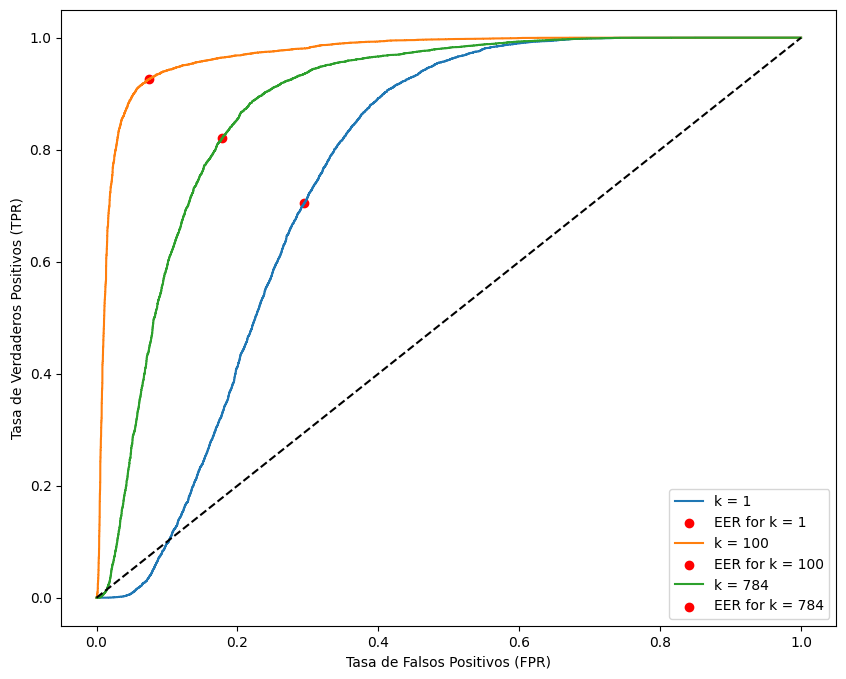

In [71]:
# f) 


def calculate_mse_for_components(x, media, avecs, k):
    # Proyección y reconstrucción
    transform = np.dot(x - media, avecs[:, :k])
    reconst = np.dot(transform, avecs[:, :k].T) + media
    # Calcular el error cuadrático medio (MSE)
    mse = np.mean((x - reconst) ** 2, axis=1)
    return mse


# Vuelvo a traer todo, y repito pasos de entrenamiento con datos de fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

n_samples_train = x_train.shape[0]
n_samples_test = x_test.shape[0]
X_train = x_train.reshape(n_samples_train, -1)  # Cada imagen es ahora un vector de 784 elementos
X_test = x_test.reshape(n_samples_test, -1)
# Tengo 60000 vectores de 784 elementos (28x28 de c/imagen)

# Calculo la media y la varianza para normalizar
u_train = np.mean(X_train, axis=0)
var_train = np.std(X_train, axis=0)

# Normalizo
X_train_norm = (X_train - u_train)/var_train

# Calculo matriz de covarianza
cov_train = np.cov(X_train_norm.T)

# Calculo AVals, AVecs de la matriz de covarianza
avals, avecs = np.linalg.eig(cov_train)

# Busco los indices que me ordenan los autovalores de mayor a menor
# Igual np.linalg.eig() me parece que los devuelve ordenados de mayor a menor
index_ordenado = np.argsort(avals)[::-1]
avals = avals[index_ordenado]
avecs = avecs[:, index_ordenado]


# Definir la cantidad de componentes a probar
components_to_test = [1, 100, 784]

# Graficar las curvas ROC para cada cantidad de componentes principales
plt.figure(figsize=(10, 8))

for k in components_to_test:
    # Calcular el MSE para k componentes
    mse = calculate_mse_for_components(x_combinado, u_train, avecs, k)
    
    # Etiqueta binaria: 0 para normales (FASHION-MNIST) y 1 para anómalas (MNIST)
    labels = np.concatenate((np.zeros(n_fashion), np.ones(n_mnist)))
    
    # Calcular la curva ROC y el área bajo la curva (AUC)
    fpr, tpr, thresholds = roc_curve(labels, mse)
    
    # Encontrar el equal error rate (EER) como el punto donde FPR ≈ 1 - TPR
    eer_threshold = thresholds[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    eer_index = np.nanargmin(np.abs(fpr - (1 - tpr)))
    eer_fpr = fpr[eer_index]
    eer_tpr = tpr[eer_index]
    
    # Graficar la curva ROC
    plt.plot(fpr, tpr, label=f'k = {k}')
    plt.scatter(eer_fpr, eer_tpr, color='red', label=f'EER for k = {k}')
    

# Configuración del gráfico
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.show()




### Interpretación

Como venimos viendo en los incisos anteriores, no siempre incrementar y usar la mayor cantidad de componentes principales asegura un mejor desempeño del algoritmo. En este caso, utilizar 100 componentes principales asegura el mejor desempeño dentro de esta comparación. Esto se debe a que es el que tiene la mayor AUC (Area Under the Curve), que en caso óptimo seria 1.

Utilizar 100 componentes principales asegura un alto TPR, manteniendo un bajo FPR, y un balance adecuado en la utilización de los recursos de computo.

Utilizar 1 componente no tiene buen desempeño por tratarse de un underfitting, mientras que lo opuesto sucede con utilizar 784 y el overfitting

Se resalta la importancia de los primeros 2 graficos (Energía y ECM), donde se puede ver que cerca del 90% de la energía de las componentes se encuentra comprendida en las primeras 100, y que el ECM al utilizar esta cantidad es bajo (y no disminuye mucho al usar, por ejemplo, 200 componentes).

### Ejercicio 3

![image.png](enunciados/ej3.png)

In [84]:
# Cargamos los datos 

data = pd.read_csv('recursos/formantes.txt', sep = '\t', header = None)
# Extraer los dos primeros formantes y las letras
X = data.iloc[:, :-2].to_numpy()
y = data.iloc[:, -1].to_numpy()               


#del data, formantes, letras

In [93]:
# a) 


def mi_kmeans(X, K, centroide_i, max_iteraciones, tol):
    centroide = centroide_i

    for _ in range(max_iteraciones):
        # Para cada punto x en X, calculo la norma, luego calculo el indice del
        # Centroide mas cercano y lo guardo en y
        y = np.array([np.argmin(np.linalg.norm(x - centroide, axis=1)) for x in X])
        # Actualizo el valor del centroide. 
        # Para cada cluster, selecciono el punto que corresponde y calculo la media en
        # el eje 0
        nuevo_centroide = np.array([X[y == k].mean(axis=0) for k in range(K)])

        # Verifico convergencia
        if np.all(np.linalg.norm(nuevo_centroide - centroide, axis=1) < tol):
            break

        centroide = nuevo_centroide

    return y, centroide


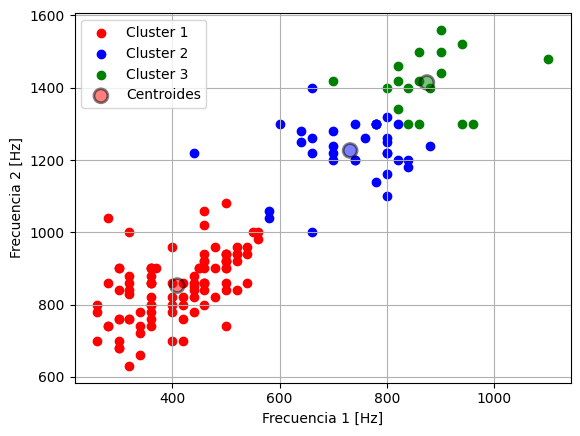

In [99]:
# b)

centroide_i = X[:3]
k = 3
max_iter = 100
tol = 1e-5

y, centroide = mi_kmeans(X, 3, centroide_i, max_iter, tol)


plt.figure()
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Cluster 1')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Cluster 2')
plt.scatter(X[y == 2, 0], X[y == 2, 1], c='green', label='Cluster 3')
plt.scatter(centroide[:, 0], centroide[:, 1], linewidths = 2, s=100, color=['red', 'blue', 'green'], edgecolor='k', alpha=0.5, marker='o', label='Centroides')
plt.xlabel('Frecuencia 1 [Hz]')
plt.ylabel('Frecuencia 2 [Hz]')
plt.legend()
plt.grid(True)
plt.show()

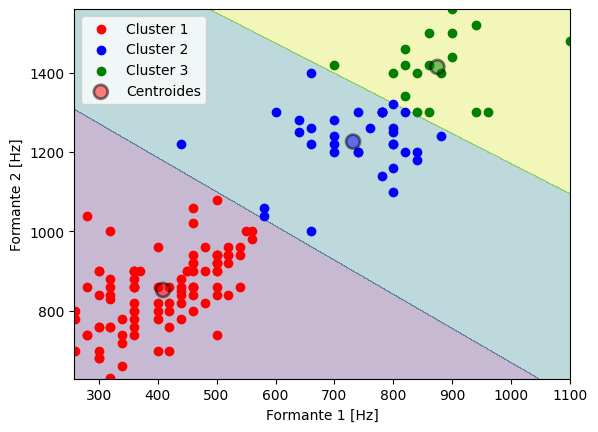

In [ ]:
# c)

# Parámetros del gráfico
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Crear una malla de puntos
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# Predecir el cluster para cada punto en la malla
Z = np.array([np.argmin(np.linalg.norm(np.array([x, y]) - centroide, axis=1))
              for x, y in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)

# Graficar las fronteras de decisión
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')


# Marcar los centroides finales
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Cluster 1')
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Cluster 2')
plt.scatter(X[y == 2, 0], X[y == 2, 1], c='green', label='Cluster 3')
plt.scatter(centroide[:, 0], centroide[:, 1], linewidths = 2, s=100, color=['red', 'blue', 'green'], edgecolor='k', alpha=0.5, marker='o', label='Centroides')
plt.xlabel('Formante 1 [Hz]')
plt.ylabel('Formante 2 [Hz]')
plt.legend()
plt.show()

### Ejercicio 4

![image.png](enunciados/ej4.png)

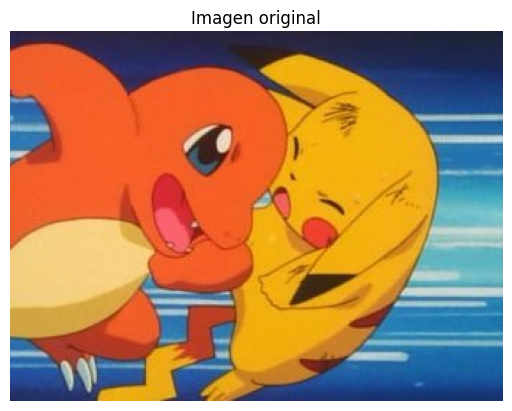

In [6]:
# Cargamos la imagen
imagen = mpimg.imread('recursos/pikachu_vs_charmander.jpeg')
plt.figure()
plt.imshow(imagen)
plt.title('Imagen original')
plt.axis('off')
plt.show()


#del imagen

In [9]:
# a) 

alto, ancho, canales = imagen.shape
pixels = imagen.reshape(-1, canales)  # Cada fila es un píxel

# Aplicar K-means para reducir la cantidad de colores
n_colores = 16
kmeans = KMeans(n_clusters=n_colores, random_state=0)
kmeans.fit(pixels)

#del alto, ancho, canales, pixels, n_colores, kmeans

KMeans(n_clusters=16, random_state=0)

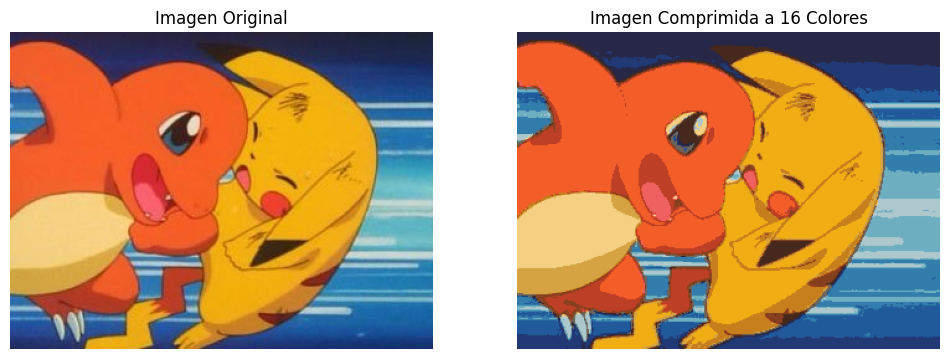

In [ ]:
# b) 

# El color promedio de cada cluster (su centroide) reemplaza a todos
# los píxeles en ese grupo.
pixels_comprimidos = kmeans.cluster_centers_[kmeans.labels_]
pixels_comprimidos = pixels_comprimidos.reshape(alto, ancho, canales).astype(np.uint8)

# Mostrar la imagen original y la comprimida
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(imagen)
ax[0].set_title("Imagen Original")
ax[0].axis('off')

ax[1].imshow(pixels_comprimidos)
ax[1].set_title("Imagen Comprimida a 16 Colores")
ax[1].axis('off')

plt.show()


In [17]:
# c)

alto, ancho, _ = imagen.shape

# Bits de la imagen original
# Cada canal ocupa 8 bits, osea 24 bits por pixel.
bits_original = alto * ancho * 24

# Bits para la imagen comprimida
# Cada centroide tiene 3 valores RGB (3 canales de 8 bits)
bits_centroides = n_colores * 3 * 8
# Para cada pixel almacenamos un numero de 4 bits que indica 
# a cual de los 16 clusters pertenece
bits_etiquetas = alto * ancho * 4
bits_comprimido = bits_centroides + bits_etiquetas

tasa_compresion = 100 - (bits_comprimido / bits_original * 100)

print(f"Bits necesarios para la imagen original: {bits_original}")
print(f"Bits necesarios para la imagen comprimida: {bits_comprimido}")
print(f"Tasa de compresion: {round(tasa_compresion, 2)}%")



Bits necesarios para la imagen original: 2095104
Bits necesarios para la imagen comprimida: 349568
Tasa de compresion: 83.32%


### Ejercicio 5

![image.png](enunciados/ej5.png)

Comenzamos definiendo los datos con los que contamos.

- Un habitante es trabajador registrado con probabilidad $\frac{\theta}{2}$
- Un habitante es trabajador informal con probabilidad $\frac{1 - \theta}{2}$
- Un habitante es desempleado con probabilidad $\frac{1}{2}$

Ademas:
- Cantidad total de habitantes: 10000
- Cantidad de trabajadores registrados: 4000


a) El objetivo es encontrar el valor de $\hat \theta$ que mejor estima al verdadero $\theta$ (el cual es desconocido), en base a los datos con los que se cuenta, y utilizando el criterio de maxima verosimilitud.

El criterio de maxima verosimilitud busca maximizar la funcion de log-verosimilitud.

Si definimos X como el numero de trabajadores registrados dentro de una muestra de 10000 habitantes, entonces

$X \sim Bin(10000, \frac{\theta}{2})$

Como contamos con que se observaron X = 4000, la funcion de verosimilitud queda

$L(\theta) = P(X = 4000 | \theta) =  \binom{10000}{4000} (\frac{\theta}{2})^{4000} (1 - \frac{\theta}{2})^{6000}$

Podemos utilizar la funcion de log-verosimilitud para simplificar los calculos

$\log L(\theta) = 4000 \log(\frac{\theta}{2}) + 6000 \log(1 - \frac{\theta}{2})$

Para maximizar esta funcion, derivamos e igualamos a 0

$\frac{d}{d \theta} \log L(\theta) = \frac{4000}{\theta} - \frac{1}{2} \cdot \frac{6000}{1 - \frac{\theta}{2}}$

Despejamos el valor de $\hat \theta$ de esta expresion

$4000 ( 1 - \frac{\hat \theta}{2}) = 3000 \hat \theta $

$4000 - 2000 \hat \theta = 3000 \hat \theta $

$\hat \theta = \frac{4000}{5000} = 0.8 $






b) Si definimos $N_R, N_I, N_D$ tal que:

- X: Cantidad de trabajadores registrados, con probabilidad $P(X) = \frac{\theta}{2}$
- Z: Cantidad de trabajadores informales, con probabilidad $P(Z) = \frac{1 - \theta}{2}$
- Y: Cantidad de trabajadores desempleados, con probabilidad $P(Y) = \frac{1}{2}$


Entonces el vector $(X, Y, Z)$ tiene una distribucion Multinomial $(n, [\frac{\theta}{2}, \frac{1 - \theta}{2}, \frac{1}{2}])$, con $n = 10000$


Queremos encontrar una estimacion de $\theta$, que maximice la verosimilitud condicional dado que se observo que  $x = 4000$


Para esto primero definimos la funcion de verosimilitud, con $a = \frac{n!}{x! y! z!}$:

$p(X = x, Z = z | \theta) = a \cdot \frac{\theta}{2}^{x} \cdot (\frac{1 - \theta}{2})^{z} \cdot (\frac{1}{2})^{n - x - z} $


Luego tomamos su logaritmo, para conseguir la funcion de log verosimilitud

$ \log p(X = x, Z = z | \theta) = q(t) =\log(a) + x \cdot \log(\frac{\theta}{2}) + z \cdot \log(\frac{1 - \theta}{2}) + (n-x-z) \cdot \log(\frac{1}{2})$
 

La esperanza de esta funcion $E_{q(t)}$ se calcula respecto de Z, y ademas Z ~ Bin(n, $\frac{1-\theta}{2}$), por lo que $E[Z] = n \cdot \frac{1-\theta}{2}$


Entonces tenemos:

$E[\log(a) + x \cdot \log(\frac{\theta}{2}) + z \cdot \log(\frac{1 - \theta}{2}) + (n-x-z) \cdot \log(\frac{1}{2})] = \log a + x \log \frac{\theta}{2} + \log \frac{1-\theta}{2} E[Z] + (n-x) \log \frac{1}{2} - \log \frac{1}{2} E[Z]$

$E_{q(t)} = \log a + x \log \frac{\theta}{2} + (n-x) \log \frac{1}{2} + E[Z] \log (1-\theta)$


Para el calculo del algoritmo EM, se deberá iterar entre el paso de esperanza (E), y el paso de maximizacion (M), hasta obtener una estimacion de $\theta$. El $\theta$ de E[Z] siempre sera el de la iteracion anterior ($\theta(t-1)$), ya que el primer paso del algoritmo es proponer un valor inicial para $\theta$, y luego hacer el paso E y el paso M.

### - Semillas y valores iniciales 

Propongo $\theta(0)$, con ese valor calculo $E[Z] = n \cdot \frac{1-\theta}{2}$, y luego la funcion de log verosimilitud (q(t)).


### - Paso E

Calculo la esperanza de la log verosimilitud, detallada arriba, pero ahora con $E[Z] = n \cdot \frac{1-\theta(t-1)}{2}$

$E_{q(t)} = \log a + x \log \frac{\theta}{2} + (n-x) \log \frac{1}{2} + n \cdot \frac{1-\theta(t-1)}{2} \log (1-\theta)$

### - Paso M

Buscamos el $\theta(t)$ que maximiza la funcion del paso anterior



c) Comenzamos derivando la log verosimilitud respecto a $\theta(t)$:

$\frac{\partial\ \log p(X = x, Z = z | \theta)}{\partial \theta(t)} = x \frac{2}{\theta(t)} \frac{1}{2} + n \frac{1-\theta(t-1)}{2} \frac{1}{1-\theta(t)} (-1) = \frac{x}{\theta(t)} - n \frac{1-\theta(t-1)}{2} \frac{1}{1-\theta(t)}$

Luego igualamos a cero


$\frac{x}{\theta(t)} - n \frac{1-\theta(t-1)}{2 \cdot (1-\theta(t))} = 0 $

$ \frac{n\cdot(1-\theta(t-1))}{2 \cdot (1-\theta(t))} = \frac{x}{\theta(t)} $

Como se nombra en el enunciado, los puntos fijos son los valores de $\theta$ que no varían al iterar un paso del algoritmo, lo que se traduce en que $\theta(t-1) = \theta(t) = \theta$

$\frac{2 (1-\theta)}{\theta} = \frac{n (1-\theta)}{x}$

$n \theta^2 - (2 x + n) \theta + 2 x = 0$


Reemplazando con n = 10000, x = 4000

$10000 \cdot \theta^2 - (2 \cdot 4000 + 10000) \theta + 2 \cdot 4000 = 0$


$10000 \cdot \theta^2 - 18000 \cdot \theta + 8000 = 0$

Resolviendo la cuadratica obtenemos:


$\theta_1 = 1$

$\theta_2 = 0.8$


Corte en Iteracion (i = 51, con diferencia = 0.0)


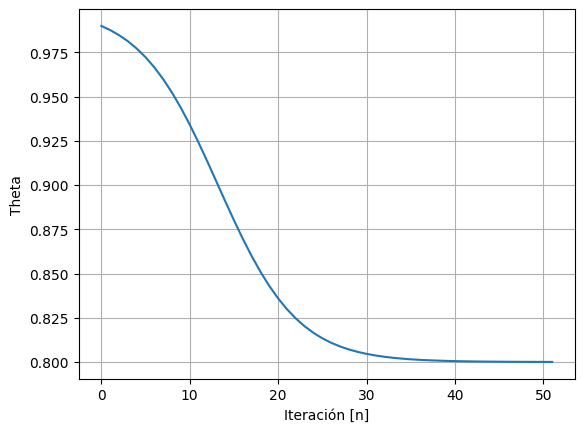

In [5]:
# d) que pasa si theta_0 = 0.99

# Pobl. total
n = 10000

# Trab. registrados observador
x = 4000

# Proponemos theta_0 = 0.99
theta = 0.99

# Armamos el vector de iteraciones de theta y le cargamos el primer resultado
theta_v = []
theta_v.append(theta)

max_iter = 1000
tol = 1e-5

for i in range(max_iter):
    # Esperanza
    esp = n * (1 - theta)/2

    # Calculo punto fijo
    theta1 = 2 * x / (n + 2 * x - n * theta)

    # Corte
    if np.abs(theta1 - theta) < tol:
        print(f"Corte en Iteracion (i = {i}, con diferencia = {round(np.abs(theta1 - theta), 2)})")
        break

    # Agrego el resultado al vector
    theta_v.append(theta1)
    theta = theta1


plt.figure()
plt.plot(theta_v)
plt.xlabel('Iteración [n]')
plt.ylabel('Theta')
plt.grid(True)
plt.show()






Como se puede ver en el grafico, por mas que $\theta_0 = 0.99$ sea un numero cercano al punto fijo $\theta_1 = 1$ (lo cual podria sonar riesgoso por estar cerca de un punto critico, que podria ser que el algoritmo "se trabe"), el algoritmo rapidamente converge a $\theta = 0.8$. Esto sugiere una robustez en el procedimiento, ya que si por alguna razon se hubiera elegido $\theta_0 = 1$ (es decir, iniciar la semilla en un punto fijo), esto podria ser corregido rapidamente con elegir cualquier otro valor cercano al mismo.

### Ejercicio 6

![image.png](enunciados/ej6.png)

In [7]:
# a)

# Parametros
pesos = [0.1, 0.4, 0.2, 0.3]
medias = [-4, 0, 4, 5]
varianzas = [1, 1.96, 1.44, 1]
desv = np.sqrt(varianzas)
n_muestras = 100

# Lista vacia
muestras = []

# Generamos las muestras de la mezcla

for _ in range(n_muestras):
    # Sorteamos una de las gaussianas
    indice_gaussiana = np.random.choice(len(pesos), p=pesos)
    # Generamos la muestra
    muestra = np.random.normal(loc=medias[indice_gaussiana], scale=desv[indice_gaussiana])
    muestras.append(muestra)

# Convierto en array()
muestras = np.array(muestras)




In [12]:
# b) IMPLEMENTAR EM para la mezcla de 6 gaussianas. Inicializar EM a pertir de K-means

def mi_kmeans2(X, K, centroide_i, max_iteraciones, tol):
    
    centroide = centroide_i

    for _ in range(max_iteraciones):
        # Para cada punto x en X, calculo la norma, luego calculo el indice del
        # Centroide mas cercano y lo guardo en y
        y = np.array([np.argmin(np.linalg.norm(x - centroide, axis=1)) for x in X])
        # Actualizo el valor del centroide. 
        # Para cada cluster, selecciono el punto que corresponde y calculo la media en
        # el eje 0
        nuevo_centroide = np.array([X[y == k].mean(axis=0) for k in range(K)])

        # Verifico convergencia
        if np.all(np.linalg.norm(nuevo_centroide - centroide, axis=1) < tol):
            break

        centroide = nuevo_centroide
        pesos = np.array([np.mean(y == k) for k in range(K)])
        varianzas = np.array([np.std(X[y == k]) for k in range(K)])

    return y, nuevo_centroide, pesos, varianzas

n_gaussianas = 6
medias_iniciales = muestras[0:n_gaussianas].reshape(-1,1)
max_iter = 100
tol = 1e-5
y, medias, pesos, varianzas = mi_kmeans2(muestras.reshape(-1,1), n_gaussianas, medias_iniciales, max_iter, tol)




Justificacion de las inicializaciones:

Medias: Como estoy agrupando en clusters, el valor de los centroides es una buena estimacion inicial para la ubicacion de las medias

Pesos: Como no tengo mucha informacion, los inicializo a todos iguales con la media de cada componente.

Varianzas: uso la varianza de los puntos asignados a cada uno de los clusters. Con esto es como que tengo la informacion a partir de la dispersion inicial de ellos.



In [19]:

max_iter2 = 1000
q = np.zeros((n_muestras, n_gaussianas))

for i in range(max_iter2):
    # Paso E
    for k in range(n_gaussianas):
        q[:, k] = pesos[k] * norm.pdf(muestras, medias[k], np.sqrt(varianzas[k]))
    q = q / np.sum(q, axis = 1).reshape(-1,1)

    # Paso M 
    pesos_est = np.mean(q, axis = 0)
    medias_est = np.sum(q * muestras[:, np.newaxis], axis=0) / np.sum(q, axis=0)
    var_est = np.sum(q * (muestras[:, np.newaxis] - medias_est)**2, axis=0) / np.sum(q, axis=0)

    # Cond. corte
    if np.all(np.abs(pesos_est - pesos) < tol) and np.all(np.abs(medias_est - medias) < tol) and np.all(np.abs(var_est - varianzas) < tol):
        print(f"Condición de corte (i = {i})")
        break


pesos2 = pesos_est
medias2 = medias_est
varianzas2 = var_est



In [20]:
# c)

gm = GaussianMixture(n_components=n_gaussianas, max_iter=max_iter2, tol=tol)
gm.fit(muestras.reshape(-1,1))

pesos_gm = gm.weights_
medias_gm = gm.means_.flatten()
varianzas_gm = gm.covariances_.flatten()


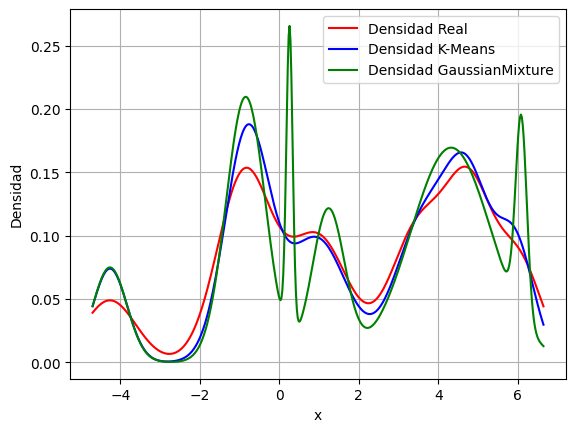

In [26]:
# d)

x_vals = np.linspace(min(muestras), max(muestras), 500)


d_real = np.zeros_like(x_vals)
d_2 = np.zeros_like(x_vals)
d_gm = np.zeros_like(x_vals)


for k in range(n_gaussianas):
    d_real += pesos[k] * norm.pdf(x_vals, medias[k], np.sqrt(varianzas[k]))
    d_2 += pesos2[k] * norm.pdf(x_vals, medias2[k], np.sqrt(varianzas2[k]))
    d_gm += pesos_gm[k] * norm.pdf(x_vals, medias_gm[k], np.sqrt(varianzas_gm[k]))


plt.figure()
plt.plot(x_vals, d_real, label='Densidad Real', c = 'r')
plt.plot(x_vals, d_2, label='Densidad K-Means', c = 'b')
plt.plot(x_vals, d_gm, label='Densidad GaussianMixture', c = 'g')
plt.xlabel('x')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.show()


### Ejercicio 7

![image.png](enunciados/ej7.png)

Datos cargados exitosamente desde sklearn.


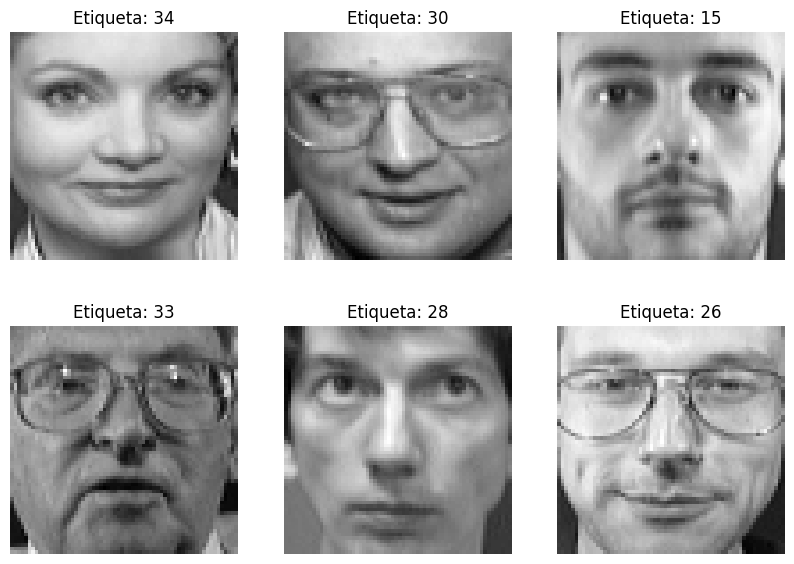

In [36]:
# a) Implemento con un try & except

try:
    dataset = fetch_olivetti_faces()
    print("Datos cargados exitosamente desde sklearn.")
except Exception as e:
    print(f"Fallo carga de archivos desde sklearn. Razon:{e}")
    print(f"Cargando archivo local")
    dataset = np.load("recursos/olivetty.npy")

X = dataset.data
y = dataset.target


# Elegir 6 imágenes al azar
indices = np.random.choice(X.shape[0], 6, replace=False)
imagenes = X[indices].reshape(-1, 64, 64)  # Reorganizar las imágenes para visualizarlas
etiquetas = y[indices]

# Graficar las imágenes seleccionadas
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
for i, ax in enumerate(axes.flat):
    ax.imshow(imagenes[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Etiqueta: {etiquetas[i]}')
plt.show()


b) El algoritmo EM puede ser utilizado para reducir la dimension de los datos con los que se esta trabajando. 

El modelo consiste en suponer que los features se pueden descomponer en factores

$$X = \mu + W \cdot Z + \epsilon$$

Con

$$\mu \in R^{d_x} $$

$$W \in R^{d_x x d_z} $$

$$Z \sim N(0, I) \ , \ \dim(Z) = d_z $$

$$ \epsilon \sim N(0, \Psi) \ , \ \dim(\epsilon) = d_x $$

$$\Psi \ \ \text{diagonal}$$

$$ Z \ , \ \epsilon \ \ \text{independientes} $$ 

En este caso queda que $\theta = \{ \mu, W, \Psi \}$

Donde:

- X son los datos observados
- W es una matriz real de pesos o factores. Establece la relacion entrelos factores latentes y las variables observadas
- Z es el vector de factores latentes
- $\epsilon$ sirve para adicionar un ruido de covarianza $\Psi$

Se puede observar que X es una combinacion lineal entre Z y $\epsilon$, que son normales independienter, y una cte. $\mu$. Es por esto que se puede decir que X|Z tambien va a tener una distribucion normal. 


Esto se debe a que si calculamos

$$E[X] = E[\mu + W Z + \epsilon]$$

$$E[X] = \mu + W E[z] + E[\epsilon]$$

$$E[X] = \mu $$

Ya que $E[z] = 0$ por ser $Z \sim N(0, I)$, y $E[\epsilon] = 0$ por ser $\epsilon \sim N(0, \Psi)$


Entonces, si quisieramos definir el siguiente vector

\begin{equation*}
\begin{pmatrix} x\\z \end{pmatrix} \sim N(\mu_{xz}, \Sigma)
\end{equation*}

Obtendriamos algo como

\begin{equation*}
\begin{pmatrix} x\\z \end{pmatrix} \sim N \left(\begin{pmatrix} \mu \\ 0 \end{pmatrix}, \begin{pmatrix} \text{var}(X) && \text{cov}(X,Z) \\ \text{cov}(Z, X) && \text{var}(Z) \end{pmatrix}\right)
\end{equation*}

Donde ahora debemos calcular $\text{var}(X)$, y tambien $\text{cov}(X, Z)$ (ya que $\text{cov}(Z,X) = \text{cov}^T(X, Z)$)

Calculamos Var(X)

$$\text{Var}(X) = \text{Var}(\mu + W Z + \epsilon) = \Psi + \text{Var}(WZ) = \Psi + W \Sigma_z W^T = \Psi + WW^T $$

Ahora calculamos Cov(X,Z)

$$ \text{Cov}(X,Z) = E[(X - \mu_x)(Z - \mu_z)^T]$$

$$ \text{Cov}(X,Z) = E[(X - \mu_x)Z^T]$$

$$ \text{Cov}(X,Z) = E[(\mu + W Z + \epsilon - \mu)Z^T]$$

$$ \text{Cov}(X,Z) = E[(W Z + \epsilon)Z^T]$$

$$ \text{Cov}(X,Z) = E[(W Z)Z^T] + E[\epsilon]E[Z^T]$$

$$ \text{Cov}(X,Z) = W E[Z Z^T] = W \text{Var}(Z) = W \ \ I = W$$

Entonces el vector que definimos queda


\begin{equation*}
\begin{pmatrix} x\\z \end{pmatrix} \sim N \left(\begin{pmatrix} \mu \\ 0 \end{pmatrix}, \begin{pmatrix} \Psi + W W^T && W \\ W^T && I \end{pmatrix} \right)
\end{equation*}

Entonces, dado que la distribucion conjunta entre (X, Z) es una normal multivariada, entonces la condicional Z|X = x tambien lo será.

En este caso 

$$(Z|X = x) \sim N (\mu, \Sigma) $$

Con:

$$\mu = \mu_z + \text{cov}(Z,X) \text{var}(X)^{-1} (x- \mu_x)$$ 

$$\mu = W^T (\Psi + W W^T)^{-1} (x - \mu) $$


$$\Sigma = \text{var}(Z) - \text{cov}(Z,X) \text{var}(X)^{-1} \text{cov}(X,Z) $$
$$ \Sigma = I - W^T (\Psi + W W^T)^{-1} W $$


## Paso E

Como nuestros parametros ahora son $\theta = \{ \mu, W, \Psi \} $ podemos definir $Q_i(z^{(i)}) = p (z^{(i)} | x^{(i)}; \mu, W, \Psi) $ como


$$ Q_i(z^{(i)}) = \frac{1}{(2 \pi)^{k/2} |\Sigma|^{1/2}} \cdot \exp{- \frac{(z_i - \mu)^T \cdot \Sigma^{-1} \cdot (z_i - \mu)}{2}} $$



## Paso M

En este paso debemos calcular la esperanza de $\log(p(X|Z, \theta))$, dado Z|X

Podemos escribir

$$Q(\theta | \theta(t)) = \sum_{i = 1}^{n} \int_{z_i} Q_i (z_i) \cdot \log(p(x_i, z_i; \theta)) d_{z_i} $$

Si dentro del logaritmo multiplicamos y dividimos por $Q_i (z_i)$ y luego operamos con propiedades de los logaritmos se obtiene

$$Q(\theta|\theta^{(t)}) = \sum_{i=1}^n (\int_{z_i} Q_i (z_i) \log(\frac{p(x_i, z_i; \theta)}{Q_i(z_i)}) d_{z_i} + \int_{z_i} Q_i(z_i) \log Q_i (z_i) d_{z_i})$$


Donde el segundo termino no depende de $\theta$, por lo cual solo se debe maximizar el primero

$$Q(\theta|\theta^{(t)}) = \sum_{i=1}^n \int_{z_i} Q_i (z_i) \log(\frac{p(x_i, z_i; \theta)}{Q_i(z_i)}) d_{z_i} $$


Si desarrollamos con los parametros $\theta = \{ \mu, W, \Psi \}$ se tiene que

$$Q(\theta|\theta^{(t)}) = \sum_{i=1}^n \int_{z_i} Q_i (z_i) \log(\frac{p(x_i, z_i; \theta)}{Q_i(z_i)}) d_{z_i}  = E_{z(i) \sim Q_i}[\log p(x_i|z_i; \theta) + \log p(z_i) - \log Q_i (z_i)]$$


Nuevamente, $\log p(z_i)$ y $\log Q_i (z_i)$ no dependen de los parametros, por lo que solo maximizamos $E_{z(i) \sim Q_i}[\log p(x_i|z_i; \theta)]$


Desarrollando $\sum_{i=1}^n E_{z(i) \sim Q_i}[\log p(x_i|z_i; \theta)]$ se obtiene

$$\sum_{i=1}^n E_{z(i) \sim Q_i}[\log p(x_i|z_i; \theta)] = \sum_{i=1}^n E \left[ \log \left( \frac{1}{(2 \pi)^{n/2} | \Psi|^{1/2}} \exp{-\frac{1}{2} (x_i - \mu - W z_i)^T \Psi^{-1} (x_i - \mu - W z_i)} \right) \right] $$


$$\sum_{i=1}^n E_{z(i) \sim Q_i}[\log p(x_i|z_i; \theta)] = \sum_{i=1}^n E \left[- \frac{n}{2} \log(2\pi) - \frac{1}{2} \log |\Psi| - \frac{1}{2} (x_i - \mu - W z_i)^T \Psi^{-1} (x_i - \mu - W z_i)  \right] $$


Esta ultima, es la expresion que debe ser maximizada respecto de cada uno de los parametros $\theta = \{ \mu, W, \Psi \}$


De esta manera, las actualizaciones quedan

$$ \mu = \frac{1}{n} \sum_{i=1}^n x_i $$

$$W = \left(\sum_{i=1}^n (x_i - \mu) \mathbb{E}[z_i | x_i]^T\right) \left(\sum_{i=1}^n \mathbb{E}[z_i z_i^T | x_i]\right)^{-1} $$


$$\Psi = \frac{1}{n} \sum_{i=1}^n \left((x_i - \mu)(x_i - \mu)^T - W \mathbb{E}[z_i | x_i] (x_i - \mu)^T\right) $$









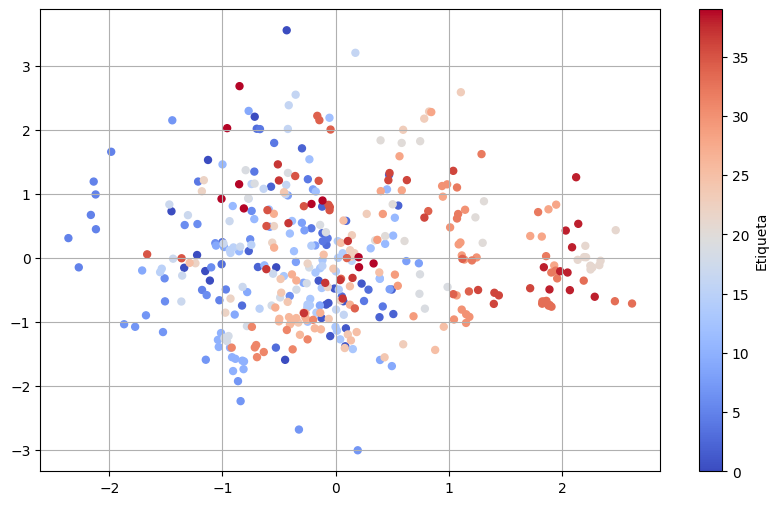

In [41]:
# c) FactorAnalysis para reducir la dim a un esp. latente normal de dim 2

# Inicializar Psi con la diag.  de la matriz de covarianza empírica de 
# los datos y utilizar la implementación lapack.

psi1 = np.diag(np.cov(X, rowvar=False))

# Factor Analysis + lapack + 2 dim latentes

fa = FactorAnalysis(n_components=2, svd_method='lapack', noise_variance_init = psi1)

fa.fit(X)
X_trans = fa.transform(X)

# Visualización de los datos transformados
plt.figure(figsize=(10, 6))
plt.scatter(X_trans[:, 0], X_trans[:, 1], c=y, cmap='coolwarm', s=25)
plt.colorbar(label='Etiqueta')
plt.grid(True)
plt.show()

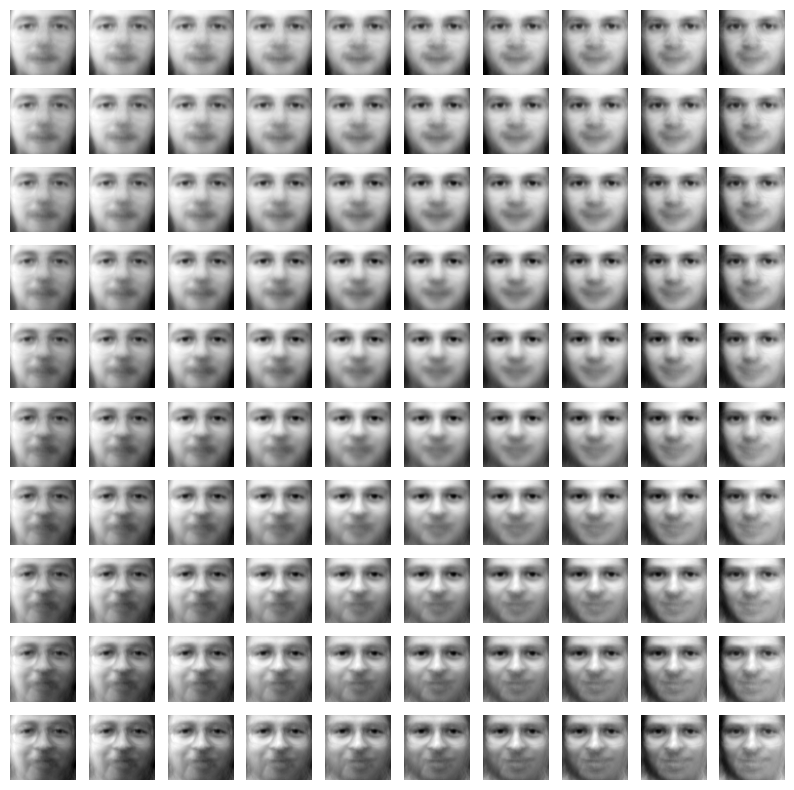

In [ ]:
# d) 


# Grilla regular de [10x10] entre [-2, 2]
grid_x = np.linspace(-2, 2, 10)
grid_y = np.linspace(-2, 2, 10)
grilla_latente = np.array([[x, y] for x in grid_x for y in grid_y])


# Media de los datos originales y la matriz W
u_X = fa.mean_
W = fa.components_.T

# Reconstruir las imágenes manualmente usando la fórmula \hat{x} = \mu + Wz
imagenes_reconstruidas = np.dot(grilla_latente, W.T) + u_X

# Graficar las 100 imágenes en una grilla de 10x10
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(imagenes_reconstruidas[i].reshape(64, 64), cmap='gray')
    ax.axis('off')
plt.show()



###  Ejercicio 8

![image.png](enunciados/ej8.png)

In [14]:
# a)

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

try:
    dataset_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
    dataset_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))
    print("Datos cargados exitosamente desde sklearn.")
except Exception as e:
    print(f"Fallo carga de archivos desde sklearn. Razon:{e}")
    print(f"Cargando archivo local")
    dataset = np.load("recursos/20news.pkl")
    dataset_train = dataset['train']
    dataset_test = dataset['test']

    

Datos cargados exitosamente desde sklearn.


In [15]:
# Definir el vectorizador TF-IDF
# lowercase = True para convertir todo a minuscula
# stop_words = 'english' usa las del idioma ingles
# use_idf=True para usar la transformacion tf-idf

vectorizer_aux = TfidfVectorizer(lowercase=True, stop_words='english', use_idf=True)

# filas: documentos, columnas: termino unico dentro del documento
aux = vectorizer_aux.fit_transform(dataset_train.data)

# Me traigo todos los features
features  = np.array(vectorizer_aux.get_feature_names_out())
# Sumo cuantas veces aparece cada termino en el documento
frecuencias = np.array(aux.sum(axis=0)).flatten()
# Busco los indices que ordenan la aparicion delos terminos segun su frecuencia
# De menor a mayor
indices = np.argsort(frecuencias) 
# Ordeno las features con los indices
features_ordenadas = features[indices]
# Calculo cuantos terminos me voy a quedar
n_terminos = int(0.2 * len(features))
# Selecciono los terminos
terminos = features_ordenadas[:n_terminos]


vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', vocabulary=terminos, use_idf = True)

X_train_vectorizer = vectorizer.fit_transform(dataset_train.data)
X_test_vectorizer = vectorizer.fit_transform(dataset_test.data)



In [ ]:
# c) 


# Crear el modelo de regresión logística
modelo = LogisticRegression(max_iter=1000, penalty=None)

# Entrenar el modelo con los datos de entrenamiento
modelo.fit(X_train_vectorizer, dataset_train.target)

# Predecir en el conjunto de testeo
y_pred = modelo.predict(X_test_vectorizer)

# Calcular el accuracy
accuracy = accuracy_score(dataset_test.target, y_pred)

print(f"Accuracy del modelo en el conjunto de testeo: {accuracy:.4f}")



Accuracy del modelo en el conjunto de testeo: 0.3585


### Ejercicio 9

![image.png](enunciados/ej9.png)

In [ ]:
# a) 

# No puedo instalar pyfasttext, porque falla la instalacion de un modulo "cysignals"
# Tampoco puedo instalar ese modulo cysignals
# Probe con versiones anteriores tanto de pyfasttest, cysignals y tambien fasttext

# Al parecer es un problema que la instalacion depende de codigo en C que W11 no 
# trae por defecto, instale https://visualstudio.microsoft.com/visual-cpp-build-tools/
# que supuestamente lo trae pero tampoco pude instalarlo



Ejercicio hecho en Colab. Link a la carpeta:

https://drive.google.com/drive/folders/1dsgogVLFpoVbe6amKlbfd21jECbq3NSp?usp=sharing

(Accesible para cualquiera con cuenta @fi.uba.ar)